# Age and Gender Detection
### Complete # TODO

# Requirements

In [1]:
import cv2
import time
import numpy as np
import os
import matplotlib.pyplot as plt

# Camera Test

In [2]:
def visualize_fps(image, fps: int):
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)
    else:
        text_color = (0, 255, 0)  

    row_size = 20 
    left_margin = 24 

    font_size = 1
    font_thickness = 2

    fps_text = "FPS = {:.1f}".format(fps)
    text_location = (left_margin, row_size)
    
    cv2.putText(
        image,
        fps_text,
        text_location,
        cv2.FONT_HERSHEY_PLAIN,
        font_size,
        text_color,
        font_thickness,
    )

    return image


In [3]:
CAMERA_DEVICE_ID = 0  
IMAGE_WIDTH = 800 
IMAGE_HEIGHT = 600  
fps = 0  

if __name__ == "__main__":  
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID) 
        while True:
            start_time = time.time()  
            _, frame = cap.read()  
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  
            cv2.imshow("frame", visualize_fps(frame, fps)) 

            end_time = time.time()  

            seconds = end_time - start_time 
            fps = 1.0 / seconds

            if cv2.waitKey(33) == 27:  
                break
    except Exception as e: 
        print(e) 
    finally:
        cv2.destroyAllWindows()  
        cap.release()  


KeyboardInterrupt: 

# Loading Video

In [4]:
CAMERA_DEVICE_ID = os.path.join("videos", "Einstein_2.mp4") 
IMAGE_WIDTH = 1000  
IMAGE_HEIGHT = 600
fps = 0  
FRAME_RATE = 30  
DURATION = 1 / FRAME_RATE

if __name__ == "__main__":  
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  

        while True:  
            start_time = time.time() 

            _, frame = cap.read()  
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  

            end_time = time.time() 

            seconds = end_time - start_time

            if seconds < DURATION:
                time.sleep(DURATION - seconds)

            seconds = time.time() - start_time
            fps = 1.0 / seconds

            cv2.imshow("frame", visualize_fps(frame, fps))

            if cv2.waitKey(33) == 27:  
                break
    except Exception as e: 
        print(e)  
    finally:
        cv2.destroyAllWindows()  
        cap.release()


KeyboardInterrupt: 

# Loading Models

In [5]:
print("--- Initializing Model Paths ---")
models_dir = os.path.join( "models")

faceProto = os.path.join(models_dir, "opencv_face_detector.pbtxt")
faceModel = os.path.join(models_dir, "opencv_face_detector_uint8.pb")
ageProto = os.path.join(models_dir, "age_deploy.prototxt")
ageModel = os.path.join(models_dir, "age_net.caffemodel")
genderProto = os.path.join(models_dir, "gender_deploy.prototxt")
genderModel = os.path.join(models_dir, "gender_net.caffemodel")

faceNet = None
ageNet = None
genderNet = None

print("\n--- Checking and Loading Face Detection Model ---")
print(f"  Framework Protoxt Path: {faceProto}")
print(f"  Model Weights Path:     {faceModel}")
print(f"  Protoxt File Exists:    {os.path.exists(faceProto)}")
print(f"  Model File Exists:      {os.path.exists(faceModel)}")

if not os.path.exists(faceProto) or not os.path.exists(faceModel):
    print("FATAL ERROR: Face detection model file(s) not found. Please ensure they are in the 'models' directory relative to your script.")
    print(f"Expected models directory: {models_dir}")
    sys.exit("Exiting due to missing face detection model files.") 
else:
    try:
        print("Attempting to load faceNet...")
        faceNet = cv2.dnn.readNet(faceModel, faceProto)
        if faceNet.empty():
            print("FATAL ERROR: cv2.dnn.readNet loaded faceNet but it is empty. The model files might be corrupted or incompatible.")
            faceNet = None
        else:
            print("SUCCESS: faceNet loaded successfully.")
    except cv2.error as e:
        print(f"OpenCV Error loading faceNet: {e}")
        faceNet = None
    except Exception as e:
        print(f"An unexpected error occurred loading faceNet: {e}")
        faceNet = None

    if faceNet is None:
        sys.exit("Exiting because faceNet could not be loaded.") 

if faceNet is not None: 
    print("\n--- Checking and Loading Age Detection Model ---")

    if os.path.exists(ageProto) and os.path.exists(ageModel):
        try:
            ageNet = cv2.dnn.readNet(ageModel, ageProto)
            if ageNet.empty(): ageNet = None; print("Error: ageNet empty.")
            else: print("ageNet loaded.")
        except Exception as e: ageNet = None; print(f"Error loading ageNet: {e}")
    else: print("Age model files not found.")


    print("\n--- Checking and Loading Gender Detection Model ---")

    if os.path.exists(genderProto) and os.path.exists(genderModel):
        try:
            genderNet = cv2.dnn.readNet(genderModel, genderProto)
            if genderNet.empty(): genderNet = None; print("Error: genderNet empty.")
            else: print("genderNet loaded.")
        except Exception as e: genderNet = None; print(f"Error loading genderNet: {e}")
    else: print("Gender model files not found.")


MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

ageList = [
    "(0-2)",
    "(4-6)",
    "(8-12)",
    "(15-20)",
    "(25-32)",
    "(38-43)",
    "(48-53)",
    "(60-100)",
]

genderList = ["Male", "Female"]



--- Initializing Model Paths ---

--- Checking and Loading Face Detection Model ---
  Framework Protoxt Path: models/opencv_face_detector.pbtxt
  Model Weights Path:     models/opencv_face_detector_uint8.pb
  Protoxt File Exists:    True
  Model File Exists:      True
Attempting to load faceNet...
SUCCESS: faceNet loaded successfully.

--- Checking and Loading Age Detection Model ---
ageNet loaded.

--- Checking and Loading Gender Detection Model ---
genderNet loaded.


# Detect Age and Gender in a Frame

In [6]:
def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDNN = frame.copy()
    frameHeight = frameOpencvDNN.shape[0]
    frameWidth = frameOpencvDNN.shape[1]
    blob = cv2.dnn.blobFromImage(
        frameOpencvDNN, 1.0, (300, 300), [104, 117, 123], True, False
    )

    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDNN, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDNN, faceBoxes


In [7]:
def detect_face_age_gender(input_frame, padding=20):
    resultImg, faceBoxes = highlightFace(faceNet, input_frame.copy()) 
    if not faceBoxes:
        return resultImg 

    for faceBox in faceBoxes:
        face = input_frame[
            max(0, faceBox[1] - padding) : min(
                faceBox[3] + padding, input_frame.shape[0] - 1
            ),
            max(0, faceBox[0] - padding) : min(
                faceBox[2] + padding, input_frame.shape[1] - 1
            ),
        ]
        
        if face.size == 0:
            continue

        blob = cv2.dnn.blobFromImage(
            face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False
        )
        
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        
        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    return resultImg


# Age and Gender Detection on Image

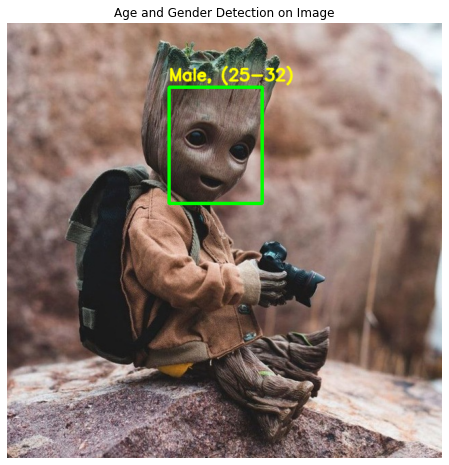

Exiting single image age/gender detection.


In [8]:
IMAGE_FILE_FOR_DETECTION = os.path.join("images", "photo_1.jpeg")
if os.path.exists(IMAGE_FILE_FOR_DETECTION):
    image_to_detect = cv2.imread(IMAGE_FILE_FOR_DETECTION)
    if image_to_detect is None:
        print(f"Error loading image: {IMAGE_FILE_FOR_DETECTION}")
    else:
        result_image = detect_face_age_gender(image_to_detect)
        
        plt.figure(figsize=(10,8))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title("Age and Gender Detection on Image")
        plt.axis('off')
        plt.show()
else:
    print(f"Image file not found: {IMAGE_FILE_FOR_DETECTION}")
print("Exiting single image age/gender detection.")


CAMERA_DEVICE_ID_AG = 0
IMAGE_WIDTH_CAM_AG = 800
IMAGE_HEIGHT_CAM_AG = 600
fps_cam_ag = 0


## Age Detection Using Webcam

In [ ]:
CAMERA_DEVICE_ID_AG = 0
IMAGE_WIDTH_CAM_AG = 800
IMAGE_HEIGHT_CAM_AG = 600
fps_cam_ag = 0

if __name__ == "__main__":
    print("Running camera age/gender detection block...")
    cap_cam_ag = None
    try:
        cap_cam_ag = cv2.VideoCapture(CAMERA_DEVICE_ID_AG)

        while True:
            start_time_cam_ag = time.time()

            hasFrame_cam_ag, frame_cam_ag = cap_cam_ag.read()
            if not hasFrame_cam_ag or frame_cam_ag is None:
                print("Error reading frame from camera or camera disconnected.")
                cv2.waitKey(0)
                break

            frame_cam_ag_resized = cv2.resize(frame_cam_ag, (IMAGE_WIDTH_CAM_AG, IMAGE_HEIGHT_CAM_AG))
            
            resultImg_cam_ag = detect_face_age_gender(frame_cam_ag_resized)

            cv2.imshow("Detecting age and gender (Camera)", visualize_fps(resultImg_cam_ag, fps_cam_ag))

            end_time_cam_ag = time.time()
            seconds_cam_ag = end_time_cam_ag - start_time_cam_ag
            if seconds_cam_ag > 0:
                fps_cam_ag = 1.0 / seconds_cam_ag

            if cv2.waitKey(33) == 27: 
                break
    except Exception as e:
        print(f"Exception in camera age/gender detection block: {e}")
    finally:
        if cap_cam_ag is not None and cap_cam_ag.isOpened():
            cap_cam_ag.release()
        cv2.destroyAllWindows()
    print("Exiting camera age/gender detection block.")



Running camera age/gender detection block...


KeyboardInterrupt: 

: 

## Age and Gender Detection Using Video

In [ ]:
VIDEO_PATH_AG = os.path.join("videos", "Jobs_2.mp4")
IMAGE_WIDTH_VID_AG = 1000
IMAGE_HEIGHT_VID_AG = 600
fps_vid_ag = 0
FRAME_RATE_VID_AG = 30 
DURATION_VID_AG = 1 / FRAME_RATE_VID_AG

if __name__ == "__main__":
    print("Running video age/gender detection block...")
    cap_vid_ag = None
    try:
        if not os.path.exists(VIDEO_PATH_AG):
            print(f"Video file not found: {VIDEO_PATH_AG}")
        else:
            cap_vid_ag = cv2.VideoCapture(VIDEO_PATH_AG)
            if not cap_vid_ag.isOpened():
                print(f"Error opening video file: {VIDEO_PATH_AG}")
            else:
                while True:
                    start_time_vid_ag = time.time()

                    hasFrame_vid_ag, frame_vid_ag = cap_vid_ag.read()

                    if not hasFrame_vid_ag:
                        print("Video ended or error reading frame.")
                        break 

                    frame_vid_ag_resized = cv2.resize(frame_vid_ag, (IMAGE_WIDTH_VID_AG, IMAGE_HEIGHT_VID_AG))
                    
                    resultImg_vid_ag = detect_face_age_gender(frame_vid_ag_resized)

                    end_time_vid_ag_proc = time.time()
                    seconds_proc_vid_ag = end_time_vid_ag_proc - start_time_vid_ag

                    if seconds_proc_vid_ag < DURATION_VID_AG:
                        time.sleep(DURATION_VID_AG - seconds_proc_vid_ag)
                    
                    final_total_seconds_vid_ag = time.time() - start_time_vid_ag
                    if final_total_seconds_vid_ag > 0:
                        fps_vid_ag = 1.0 / final_total_seconds_vid_ag
                    
                    cv2.imshow("Detecting age and gender (Video)", visualize_fps(resultImg_vid_ag, fps_vid_ag))

                    if cv2.waitKey(33) == 27:
                        break
    except Exception as e:
        print(f"Exception in video age/gender detection block: {e}")
    finally:
        if cap_vid_ag is not None and cap_vid_ag.isOpened():
            cap_vid_ag.release()
        cv2.destroyAllWindows()
    print("Exiting video age/gender detection block.")

print("Script finished.")


Running video age/gender detection block...
Exception in video age/gender detection block: 'NoneType' object has no attribute 'setInput'
Exiting video age/gender detection block.
Script finished.
